<a href="https://colab.research.google.com/github/Flamisell/StewartPlatformSingularities_py/blob/main/stweart_platform_singularities_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stewart Platform Singularities Generation

This notebook is propedeutic for the design of a stewart platform's controller with local singularity avoidance.

When the local condition index of the transpose Jacobian matrix approaches zero, the required actuator forces become infinitely large, making it impossible for the platform to move. In a real-world scenario, this results in the platform becoming stuck in specific configurations, often requiring manual intervention to release it. Avoiding this points is crucial for a continuos motion.

Singularities are determined by the Jacobian matrix of the platform, which in turn depends on the platform's geometry and configuration. Finding these configurations in advance allows us to create an offline set of configurations to avoid.

# Stewart Platform Class

This class has multiple purposes which will not be discussed here, the key function that is used in this notebook is the *getSingularityWorkspace* function.

By defining the workspace boundaries (in terms of position and orientation), the local condition index of the transposed Jacobian matrix is calculated for each pose.



In [ ]:
# @title Sterwart Platform Class
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt


class StewartPlatform:

    def __init__(self, r_b , phi_b , r_p, phi_p):
        self.r_b = r_b # radius of base
        self.phi_b = phi_b # angle between base joints
        self.r_p = r_p # radius of platform
        self.phi_p = phi_p # angle between platform joints
        self.options = {
            1: self.getSingularValueIndex,
            2: self.getManipulabilityIndex,
            3: self.getConditionNumber,
            4: self.getLocalConditionIndex,
            5: self.getLDI,
            6: self.getLocalConditionIndexT
        }

    ############################################ IK ##############################################
    def __inverse_kinematics(self, pose): ## Inverse Kinematics (Vectorial Closing Loop)
        if len(pose) != 6:
            raise ValueError("Pose must be a 6-element list or array")

        self.p_i = np.zeros([6, 3])
        self.b_i = np.zeros([6, 3])
        self.l_i = np.zeros([6, 3])
        self.l_i_unit = np.zeros([6, 3])

        self.pose_vect = pose
        x_p, y_p, z_p, roll, pitch, yaw = pose

        self.r = R.from_euler("ZYX", (yaw, pitch, roll), degrees=True)  #rotation matrix
        angles = np.array([0, 120, 120, 240, 240, 0])

        for i in range(6):
            j = -1 if (i % 2) == 1 else 1
            self.b_i[i, 0] = self.r_b * np.cos(np.deg2rad(angles[i] + j * self.phi_b / 2)) # base points
            self.b_i[i, 1] = self.r_b * np.sin(np.deg2rad(angles[i] + j * self.phi_b / 2))
            self.p_i[i, 0] = self.r_p * np.cos(np.deg2rad(angles[i] + j * self.phi_p / 2)) # platform points
            self.p_i[i, 1] = self.r_p * np.sin(np.deg2rad(angles[i] + j * self.phi_p / 2))
            self.l_i[i, :] = np.array([x_p, y_p, z_p]) + self.r.as_matrix().dot(self.p_i[i]) - self.b_i[i] # legs vectors
            self.l_i_unit[i, :] = self.l_i[i, :] / np.linalg.norm(self.l_i[i, :]) # unit legs vectors
            self.p_i[i] = self.l_i[i, :] + self.b_i[i] # moving platform points wrt base frame

        return self.l_i

    def getIK(self, pose):
        return self.__inverse_kinematics(pose)

    ############################################ Jacobian ##############################################
    def __jacobian(self): # Calculate Jacobian q_dot=Jacobian*x_dot
        if not hasattr(self, 'l_i_unit') or not hasattr(self, 'p_i'):
            raise AttributeError("Run inverse kinematics before calculating the Jacobian")
        self.jacobian = np.zeros([6, 6])
        for i in range(6):
            lastcols = np.cross(self.r.as_matrix().dot(self.p_i[i]), self.l_i_unit[i])
            self.jacobian[i, :3] = self.l_i_unit[i]
            self.jacobian[i, 3:] = lastcols

        return self.jacobian

    def getJacobian(self):
        return self.__jacobian()

    ############################################ FK ##############################################
    def __forward_kinematics(self, starting_pose, lengths_desired, plot_flag): # Newton Method Optimization.
        if not isinstance(starting_pose, (list, np.ndarray)) or len(starting_pose) != 6:
            raise ValueError("Starting pose must be a list or numpy array with 6 elements")
        if not isinstance(lengths_desired, (list, np.ndarray)) or len(lengths_desired) != 6:
            raise ValueError("Lengths desired must be a list or numpy array with 6 elements")

        self.pose_vect = starting_pose
        x_p, y_p, z_p, roll, pitch, yaw = starting_pose
        self.r = R.from_euler("ZYX", (yaw, pitch, roll), degrees=True)

        # Newton Method Parameters
        max_count = 100
        epsilon = 0.001
        alpha_pos = 0.2
        alpha_rot = 0.2
        # variables
        est_pose_vect = np.copy(starting_pose)
        est_pose = np.zeros([4, 4])
        est_pose[:3, :3] = self.r.as_matrix()
        est_pose[:3, 3] = [x_p, y_p, z_p]
        est_pose[3, 3] = 1
        delta_lengths = np.zeros(6)
        delta_T = np.identity(4)
        error = epsilon + 1
        count = 0

        while error > epsilon and count < max_count:
            # find new variables
            legs_est = self.__inverse_kinematics(est_pose_vect)
            lengths_est = np.linalg.norm(legs_est, axis=1)
            delta_lengths = lengths_desired - lengths_est
            J = self.__jacobian()
            J_T = J.transpose()
            # find x_delta with pseudoinverse
            J_star = np.linalg.inv(J_T.dot(J) + 0.0001 * np.identity(6)).dot(J_T)
            x_delta = np.dot(J_star, delta_lengths)
            x_delta_pos = x_delta[:3] * alpha_pos
            x_delta_rot = x_delta[3:] * alpha_rot
            # transform x_delta to delta_T
            r_delta = R.from_euler("ZYX", x_delta_rot)
            delta_T[:3, :3] = r_delta.as_matrix()
            delta_T[:3, 3] = x_delta[:3]
            # move pose
            est_pose = np.dot(delta_T, est_pose)
            # transform est_pose to est_pose_vect
            est_pose_vect[:3] = est_pose[:3, 3]
            self.r_pos = R.from_matrix(est_pose[:3, :3])
            est_pose_vect[3:] = self.r_pos.as_euler("ZYX", degrees=True)
            # find error and update counter
            error = np.linalg.norm(delta_lengths)
            count += 1

            # Uncomment to plot during FK procedure
            if plot_flag:
              self.plot()

        if count < max_count:
            self.pose_vect = est_pose_vect
            # print("Forward Kinematics converged!")
            # print("Estimated pose:", est_pose_vect)
            # print("Desired Lengths:", lengths_desired)
            # print("Estimated Lengths:", lengths_est)
            # print("Error:", error)
            # print("Iterations:", count)
        else:
            print("Forward Kinematics did not converge")
            print("Estimated pose:", est_pose_vect)
            print("Desired Lengths:", lengths_desired)
            print("Estimated Lengths:", lengths_est)
            print("Error:", error)
            print("Iterations:", count)

        return self.pose_vect

    def getFK(self, starting_pose, lengths_desired, plot_flag):
        return self.__forward_kinematics(starting_pose, lengths_desired, plot_flag)

    ############################################ Kinematic Analysis ##############################################
    def __find_singular_value_index(self): # measures drive capability of the platform, finds max q_dot under unitary x_dot
        J = self.__jacobian()
        eigenvalues = np.linalg.eigvals(J.T.dot(np.linalg.inv(J)))
        sigma_max = np.abs(np.sqrt(np.max(eigenvalues)))
        return sigma_max

    def getSingularValueIndex(self):
        return self.__find_singular_value_index()

    def __find_manipulability_index(self): # Measures manipulability of manipulator, can be used to optimize it's configuration
        J = self.__jacobian()
        JJ = J.dot(J.T)
        w = np.sqrt(np.linalg.det(JJ))
        return w

    def getManipulabilityIndex(self):
        return self.__find_manipulability_index()

    def __find_condition_number(self): # Measures closeness to isotropic configuration [1,+ inf)
        J = self.__jacobian()
        cond_num = np.linalg.cond(J)
        return cond_num

    def getConditionNumber(self):
        return self.__find_condition_number()

    def __find_local_condition_index(self): # Measures closeness to isotropic configuration (0,1]
        eta = 1 / self.__find_condition_number()
        return eta

    def getLocalConditionIndex(self):
        return self.__find_local_condition_index()

    ############################################ Force Analysis ##############################################
    def __find_platform_forces(self, F_actuators): # Finds platform forces given by actuator forces
        if not isinstance(F_actuators, (list, np.ndarray)) or len(F_actuators) != 6:
            raise ValueError("F_actuators must be a list or numpy array with 6 elements")
        J_T = self.__jacobian().T
        F_platform = J_T.dot(F_actuators)
        return F_platform

    def getPlatformForces(self, F_actuators):
        return self.__find_platform_forces(F_actuators)

    def __find_actuator_forces(self, F_platform): # Finds actuator forces given by platform forces
        if not isinstance(F_platform, (list, np.ndarray)) or len(F_platform) != 6:
            raise ValueError("F_platform must be a list or numpy array with 6 elements")

        J_Inv = np.linalg.inv(self.__jacobian().T) # only when Jacobian is invertible
        F_actuators = J_Inv.dot(F_platform)
        return F_actuators

    def getActuatorForces(self, F_platform):
        return self.__find_actuator_forces(F_platform)

    def __find_force_ellipsoid(self): # Finds force ellipsoid (excluding moment vectors)
        J_T = self.__jacobian().T
        JJ = J_T.dot(J_T.T)
        A = JJ[:3, :3] # Lagrangian
        eigenvalues, eigenvectors = np.linalg.eig(A)

        Force_ellipsoid_1 = eigenvectors[:, 0] * np.abs(eigenvalues[0])
        Force_ellipsoid_2 = eigenvectors[:, 1] * np.abs(eigenvalues[1])
        Force_ellipsoid_3 = eigenvectors[:, 2] * np.abs(eigenvalues[2])

        return [Force_ellipsoid_1, Force_ellipsoid_2, Force_ellipsoid_3]

    def getForceEllipsoid(self):
        return self.__find_force_ellipsoid()

    def __find_ldi(self):  # Local design index for Force transmittability (actuator design)
        J_T = self.__jacobian().T
        JJ = J_T.dot(J_T.T)
        A = JJ[:3, :3] # Lagrangian
        eigenvalues, _ = np.linalg.eig(A)
        R_f = np.abs(np.sqrt(np.min(eigenvalues))) # take minimum magnitude of force ellipsoid for actuator design
        LDI_f = 1 / R_f # local design index
        return LDI_f

    def getLDI(self):
        return self.__find_ldi()

    def __find_local_condition_index_T(self):  # Measures closeness to isotropic force configuration (0,1] 0 is singularity.
      J_T = self.__jacobian().T
      cond_num = np.linalg.cond(J_T)
      eta_T = 1 / cond_num
      return eta_T

    def getLocalConditionIndexT(self):
      return self.__find_local_condition_index_T()

    ############################################ Workspace Analysis #########################################

    def __find_index_workspace_position(self, RPY ,workspace_limits, N, choice):
        # Validate inputs
        if not isinstance(workspace_limits, (list, np.ndarray)) or len(workspace_limits) != 6:
            raise ValueError("workspace_limits must be a list or array of 6 elements")
        if not isinstance(RPY, (list, np.ndarray)) or len(RPY) != 3:
            raise ValueError("RPY must be a list or array of 3 elements")
        if not isinstance(N, int) or N <= 0:
            raise ValueError("N must be a positive integer")
        if choice not in self.options:
            raise ValueError(f"Invalid choice for index calculation. Valid choices are: {list(self.options.keys())}")

        # Define discretization space
        x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits
        roll, pitch, yaw = RPY

        # Ensure workspace limits are valid
        if x_min >= x_max or y_min >= y_max or z_min >= z_max:
            raise ValueError("Workspace limits must define a valid range (min < max) for each dimension")

        # Discretization vectors
        try:
            x_vect = np.linspace(x_min, x_max, N)
            y_vect = np.linspace(y_min, y_max, N)
            z_vect = np.linspace(z_min, z_max, N)
        except Exception as e:
            raise ValueError(f"Error in creating discretization vectors: {e}")

        xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
        positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T
        orientations = np.array([roll, pitch, yaw])

        Holder = []

        for pos in positions:
            p_vect = np.hstack((pos, orientations))
            try:
                self.getIK(p_vect)
                Index = self.options[choice]()
                Holder.append(np.append(pos, Index))
            except Exception as e:
                print(f"Error in calculating index for position {pos}: {e}")
                continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getIndexWorkspacePosition(self, RPY, workspace_limits, N, choice):
        return self.__find_index_workspace_position(RPY,workspace_limits , N, choice)

    def __find_index_workspace_orientation(self, position, orientation_limits, N, choice):
        # Validate inputs
        if not isinstance(position, (list, np.ndarray)) or len(position) != 3:
            raise ValueError("position must be a list or array of 3 elements")
        if not isinstance(orientation_limits, (list, np.ndarray)) or len(orientation_limits) != 6:
            raise ValueError("orientation_limits must be a list or array of 6 elements")
        if not isinstance(N, int) or N <= 0:
            raise ValueError("N must be a positive integer")
        if choice not in self.options:
            raise ValueError(f"Invalid choice for index calculation. Valid choices are: {list(self.options.keys())}")

        # Define discretization space
        roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits

        # Ensure orientation limits are valid
        if roll_min >= roll_max or pitch_min >= pitch_max or yaw_min >= yaw_max:
            raise ValueError("Orientation limits must define a valid range (min < max) for each dimension")

        # Discretization vectors
        try:
            roll_vect = np.linspace(roll_min, roll_max, N)
            pitch_vect = np.linspace(pitch_min, pitch_max, N)
            yaw_vect = np.linspace(yaw_min, yaw_max, N)
        except Exception as e:
            raise ValueError(f"Error in creating discretization vectors: {e}")

        rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
        orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

        Holder = []

        for orient in orientations:
            p_vect = np.hstack((position, orient))
            try:
                self.getIK(p_vect)
                Index = self.options[choice]()
                Holder.append(np.append(orient, Index))
            except Exception as e:
                print(f"Error in calculating index for orientation {orient}: {e}")
                continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getIndexWorkspaceOrientation(self, position, orientation_limits, N, choice):
        return self.__find_index_workspace_orientation(position, orientation_limits, N, choice)

    def __find_index_workspace(self, workspace_limits, orientation_limits, N_pos, N_orient, choice):
        # Validate inputs
        if not isinstance(workspace_limits, (list, np.ndarray)) or len(workspace_limits) != 6:
            raise ValueError("workspace_limits must be a list or array of 6 elements")
        if not isinstance(orientation_limits, (list, np.ndarray)) or len(orientation_limits) != 6:
            raise ValueError("orientation_limits must be a list or array of 6 elements")
        if not isinstance(N_pos, int) or N_pos <= 0:
            raise ValueError("N_pos must be a positive integer")
        if not isinstance(N_orient, int) or N_orient <= 0:
            raise ValueError("N_orient must be a positive integer")
        if choice not in self.options:
            raise ValueError(f"Invalid choice for index calculation. Valid choices are: {list(self.options.keys())}")

        # Define discretization space for positions
        x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits
        if x_min >= x_max or y_min >= y_max or z_min >= z_max:
            raise ValueError("Workspace limits must define a valid range (min < max) for each dimension")

        x_vect = np.linspace(x_min, x_max, N_pos)
        y_vect = np.linspace(y_min, y_max, N_pos)
        z_vect = np.linspace(z_min, z_max, N_pos)

        xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
        positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

        # Define discretization space for orientations
        roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits
        if roll_min >= roll_max or pitch_min >= pitch_max or yaw_min >= yaw_max:
            raise ValueError("Orientation limits must define a valid range (min < max) for each dimension")

        roll_vect = np.linspace(roll_min, roll_max, N_orient)
        pitch_vect = np.linspace(pitch_min, pitch_max, N_orient)
        yaw_vect = np.linspace(yaw_min, yaw_max, N_orient)

        rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
        orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

        # Iterate through each position and each orientation
        Holder = []
        for pos in positions:
            for orient in orientations:
                p_vect = np.hstack((pos, orient))
                try:
                    self.getIK(p_vect)
                    Index = self.options[choice]()
                    Holder.append(np.append(p_vect, Index))
                except Exception as e:
                    print(f"Error in calculating index for position {pos} and orientation {orient}: {e}")
                    continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getIndexWorkspace(self, workspace_limits, orientation_limits, N_pos, N_orient, choice):
        return self.__find_index_workspace(workspace_limits, orientation_limits, N_pos, N_orient, choice)

    def __find_singularity_workspace(self, workspace_limits, orientation_limits, N_pos, N_orient):
        # Validate inputs
        if not isinstance(workspace_limits, (list, np.ndarray)) or len(workspace_limits) != 6:
            raise ValueError("workspace_limits must be a list or array of 6 elements")
        if not isinstance(orientation_limits, (list, np.ndarray)) or len(orientation_limits) != 6:
            raise ValueError("orientation_limits must be a list or array of 6 elements")
        if not isinstance(N_pos, int) or N_pos <= 0:
            raise ValueError("N_pos must be a positive integer")
        if not isinstance(N_orient, int) or N_orient <= 0:
            raise ValueError("N_orient must be a positive integer")

        self.workspace_limits = workspace_limits
        self.orientation_limits = orientation_limits

        # Define discretization space for positions
        x_min, x_max, y_min, y_max, z_min, z_max = self.workspace_limits
        if x_min >= x_max or y_min >= y_max or z_min >= z_max:
            raise ValueError("Workspace limits must define a valid range (min < max) for each dimension")


        x_vect = np.linspace(x_min, x_max, N_pos)
        y_vect = np.linspace(y_min, y_max, N_pos)
        z_vect = np.linspace(z_min, z_max, N_pos)

        xx, yy, zz = np.meshgrid(x_vect, y_vect, z_vect, indexing='ij')
        positions = np.vstack([xx.ravel(), yy.ravel(), zz.ravel()]).T

        # Define discretization space for orientations
        roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = self.orientation_limits
        if roll_min >= roll_max or pitch_min >= pitch_max or yaw_min >= yaw_max:
            raise ValueError("Orientation limits must define a valid range (min < max) for each dimension")

        roll_vect = np.linspace(roll_min, roll_max, N_orient)
        pitch_vect = np.linspace(pitch_min, pitch_max, N_orient)
        yaw_vect = np.linspace(yaw_min, yaw_max, N_orient)

        rr, pp, yy = np.meshgrid(roll_vect, pitch_vect, yaw_vect, indexing='ij')
        orientations = np.vstack([rr.ravel(), pp.ravel(), yy.ravel()]).T

        # Select 1/condition number for J_T
        choice=6

        # Iterate through each position and each orientation
        Holder = []
        for pos in positions:
            for orient in orientations:
                p_vect = np.hstack((pos, orient))
                try:
                    self.getIK(p_vect)
                    Index = self.options[choice]()
                    if Index <0.001:
                      Holder.append(np.append(p_vect, Index))
                except Exception as e:
                    print(f"Error in calculating index for position {pos} and orientation {orient}: {e}")
                    continue

        if not Holder:
            raise RuntimeError("No valid indices calculated. Check the input parameters and IK method.")

        Holder = np.array(Holder)
        return Holder

    def getSingularityWorkspace(self, workspace_limits, orientation_limits, N_pos, N_orient): # returns the value of the local condition indexT for every point in space
        # Choosing N_pos and N_orient too high may result in a computational expensive operation, suggested values ( N_pos=10, N_orient=10 )
        # for practical usage there is the need to filter the data. Suggestion: filter by local condition index value AND by distance between data points (from scipy.spatial.distance import cdist).
        return self.__find_singularity_workspace(workspace_limits, orientation_limits, N_pos, N_orient)


    ############################################ Singularity for Obstacle avoidance #########################

    def loadSingularitiesTaskSpace(self,singularities,workspace_limits,orientation_limits): # Load singularities poses into robot for obstacle avoidance
        self.workspace_limits = workspace_limits
        self.orientation_limits = orientation_limits
        self.singularities_task_space = singularities
        if self.singularities_task_space.size == 0:
          print("no singularities loaded!")
        return

    def __find_closest_singularity(self,pose):
        if self.singularities_task_space.size == 0:
          return np.array([0,0,0,0,0,0])
        else:
          x_min, x_max, y_min, y_max, z_min, z_max = self.workspace_limits
          roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = self.orientation_limits
          mins=np.array([x_min,y_min,z_min,roll_min,pitch_min,yaw_min])
          maxs=np.array([x_max,y_max,z_max,roll_max,pitch_max,yaw_max])

          # Normalize each component
          normalized_pose = (pose - mins) / (maxs - mins)
          normalized_singularities=(self.singularities_task_space-mins)/(maxs-mins) # should be done only once

          # Find distance between pose and singularities
          distances = np.linalg.norm(normalized_singularities - normalized_pose, axis=1)
          # Find the index of the minimum distance
          min_index = np.argmin(distances)

          # # Return the closest singularity pose
          self.closest_singularity = self.singularities_task_space[min_index]
          return self.closest_singularity

    def getClosestSingularity(self, pose):
        # be careful to be coherent with the workspace limits used in getSingularityWorkspace(workspace_limits, orientation_limits, N_pos, N_orient)
        return self.__find_closest_singularity(pose)


    ############################################ Plot Platform ##############################################
    def plot(self):
        if not hasattr(self, 'p_i'):
          raise AttributeError("Run inverse kinematics before calling the Plot function")
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title("Stewart Platform")

        ax.plot(self.p_i[:, 0], self.p_i[:, 1], self.p_i[:, 2], color='b', lw=3)
        ax.plot([self.p_i[5, 0], self.p_i[0, 0]], [self.p_i[5, 1], self.p_i[0, 1]], [self.p_i[5, 2], self.p_i[0, 2]], color='b', lw=3)
        ax.scatter(self.p_i[:, 0], self.p_i[:, 1], self.p_i[:, 2], color='c', marker='o')

        ax.plot(self.b_i[:, 0], self.b_i[:, 1], self.b_i[:, 2], color='b')
        ax.plot([self.b_i[5, 0], self.b_i[0, 0]], [self.b_i[5, 1], self.b_i[0, 1]], [self.b_i[0, 2], self.b_i[0, 2]], color='b')
        ax.scatter(self.b_i[:, 0], self.b_i[:, 1], self.b_i[:, 2], color='c', marker='o')

        for i in range(6):
            ax.plot([self.b_i[i, 0], self.p_i[i, 0]], [self.b_i[i, 1], self.p_i[i, 1]], [self.b_i[i, 2], self.p_i[i, 2]], color='k', lw=3)

        displacement = 0.03
        for x, y, z, i in zip(self.b_i[:, 0], self.b_i[:, 1], self.b_i[:, 2], range(len(self.b_i[:, 0]))):
            ax.text(x + displacement, y + displacement, z, i)

        ax.quiver(0, 0, 0, 1, 0, 0, color='r', lw=0.5, length=0.2)
        ax.quiver(0, 0, 0, 0, 1, 0, color='g', lw=0.5, length=0.2)
        ax.quiver(0, 0, 0, 0, 0, 1, color='b', lw=0.5, length=0.2)

        x_limits = ax.get_xlim3d()
        y_limits = ax.get_ylim3d()
        z_limits = ax.get_zlim3d()
        x_range = abs(x_limits[1] - x_limits[0])
        x_middle = np.mean(x_limits)
        y_range = abs(y_limits[1] - y_limits[0])
        y_middle = np.mean(y_limits)
        z_range = abs(z_limits[1] - z_limits[0])
        z_middle = np.mean(z_limits)
        plot_radius = 0.5 * max([x_range, y_range, z_range])

        ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
        ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
        ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')

        plt.show()

# Singularity search

The steps to obtain an offline set of singular configurations is presented here below.

**1) Platform initialization**

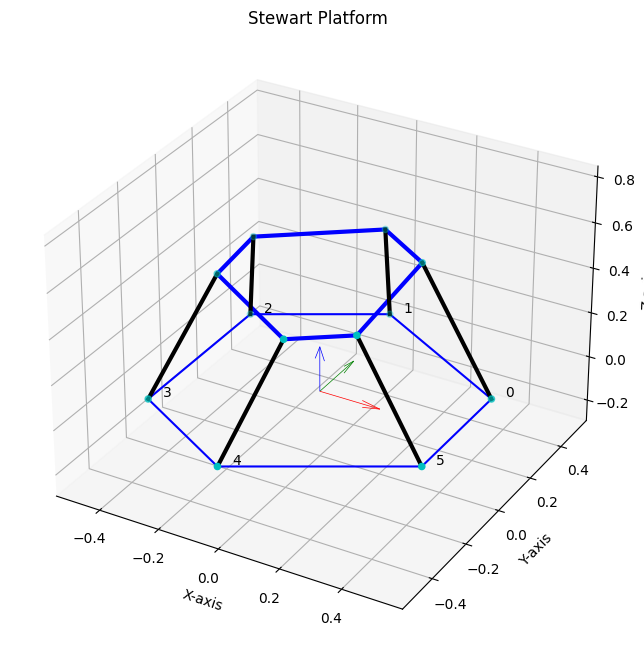

In [ ]:
# Define parameters
r_b = 0.5  # Radius of base
phi_b = 50  # Angle between base joints
r_p = 0.3  # Radius of platform
phi_p = 80  # Angle between platform joints

# Create Stewart Platform instance
platform = StewartPlatform(r_b, phi_b, r_p, phi_p)
pos=np.array([0,0,0.5])
orient=np.array([10,0,0])
lengths= platform.getIK( np.hstack((pos,orient)))
k=platform.getLocalConditionIndexT() # tells you how close you are to a singularity

# define workspace and orientation limints
workspace_limits = [-0.5, 0.5, -0.5, 0.5, 0.1, 0.6]
orientation_limits = [-10, 10, -10, 10, -10, 10]
x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits
roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits

platform.plot()

Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2) Singularity search**

Use *getSingularityWorkspace* to search for any pose which has a low local condition index. Note: this can be computationally expensive.


In [ ]:
N_pos=10 # Discretization for workspace coordinates
N_orient=10 # Discretization for orientation coordinates
## Uncomment to start the search
# Holder=platform.getSingularityWorkspace(workspace_limits,orientation_limits,N_pos,N_orient) # find singularities in all space


Save the singularities onto drive for safety.

In [ ]:
## Uncomment to load the singularities
## save the whole txt
# with open('/content/drive/My Drive/Github/singularities_2.txt', 'w') as f:
#     np.savetxt(f, Holder)

Load the whole singularity file.

In [ ]:
# load the whole text
with open('/content/drive/My Drive/Github/singularities_2.txt', 'r') as f:
    singularities = np.loadtxt(f)

print(len(singularities))

12366


**3) Singularity Filtering**

*First Filtering*

Slicing the matrix, removing the borders of the workspace (external singularities) and selecting only the poses with low local condition index.

In [ ]:
# first filtering
keep_mask = (singularities[:, 6] < 0.001) & (singularities[:, 2] > z_min)& (singularities[:, 2] < z_max) & (singularities[:, 0] < x_max)& (singularities[:, 0] > x_min)& (singularities[:, 1] < y_max) & (singularities[:, 1] > y_min)
interest_points_with_index=singularities[keep_mask]
print(len(interest_points_with_index))

4136


*Second filtering*

We normalize the singularities between the borders of the workspace, we then calculate the distance matrix between all of them and remove the configurations which are too close to each other.

In [ ]:
# take only poses
interest_points=interest_points_with_index[:,:6]
#normalize the singularities poses
mins=np.array([x_min,y_min,z_min,roll_min,pitch_min,yaw_min])
maxs=np.array([x_max,y_max,z_max,roll_max,pitch_max,yaw_max])
normalized_interest_points = (interest_points - mins) / (maxs - mins)


In [ ]:
from scipy.spatial.distance import cdist
# second filtering

threshold=0.3
distances = cdist(normalized_interest_points, normalized_interest_points)
# To avoid self-comparison, set the diagonal to a large value
np.fill_diagonal(distances, np.inf)

index_holder=[]
interest_points_holder=np.copy(interest_points_with_index)
keep_mask = np.ones(normalized_interest_points.shape[0], dtype=bool)
for i in range(normalized_interest_points.shape[0]):
    interest_points_holder[i][6]=i
    if keep_mask[i]:
        # Find indices of vectors within the threshold distance
        close_indices = np.where(distances[i] < threshold)[0]
        # Set keep_mask to False for these indices
        keep_mask[close_indices] = False
        # Ensure we don't set the current vector's mask to False
        keep_mask[i] = True


interest_points_filtered=interest_points_holder[keep_mask] # kept singularities
interest_points_deleted=interest_points_holder[~keep_mask] # removed singularities
print(len(interest_points_filtered))
print(len(interest_points_deleted))

284
3852


Save singularities in task space and in joint space.

In [ ]:
# Save the filtered singularities as task singularities
singularities_task_space=np.copy(interest_points_filtered[:,:6])
with open('/content/drive/My Drive/Github/filtered_singularities_task_space_2.txt', 'w') as f:
    np.savetxt(f, singularities_task_space)

# Save the filtered singularities as joint singularities
singularities_joint_space=np.copy(interest_points_filtered[:,:6])
for i in range(len(singularities_task_space)):
  singularities_joint_space[i,:]=np.linalg.norm(platform.getIK(singularities_task_space[i,:]),axis=1)
with open('/content/drive/My Drive/Github/filtered_singularities_joint_space_2.txt', 'w') as f:
    np.savetxt(f, singularities_joint_space)

# Closest singularity search and visualization

In this section is shown how to search for the closest singularity given a configuration of the platform and how to visualize the singularity space in both position and orientation space. Note: stewart platform's singularities live in R6, to visualize them we need to fix either position or orientation of the platform.

Load the singularities from the drive.

In [ ]:
## load the singularities

with open('/content/drive/My Drive/Github/filtered_singularities_task_space_2.txt', 'r') as f:
    singularities_task_space = np.loadtxt(f)

# print(len(singularities_task_space))

with open('/content/drive/My Drive/Github/filtered_singularities_joint_space_2.txt', 'r') as f:
    singularities_joint_space = np.loadtxt(f)

# print(len(singularities_joint_space))

Find the closest singularity to defined position.

Check local condition index and the actuator forces in pose and singularity.

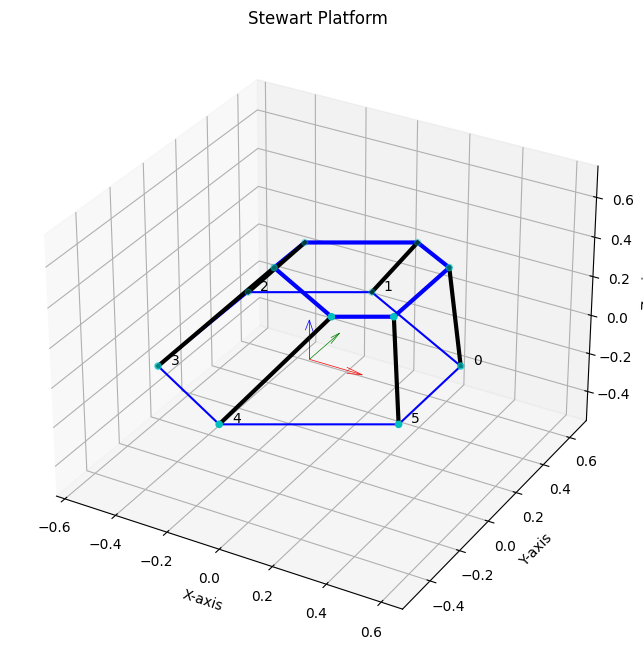

pose : [0.   0.35 0.2  0.   0.   0.  ]
local condition number T : 0.041514649773245295
joint_forces : [  8.10956876 -11.38459298   7.12788875  14.39272842 -25.46613719
   8.61847273]


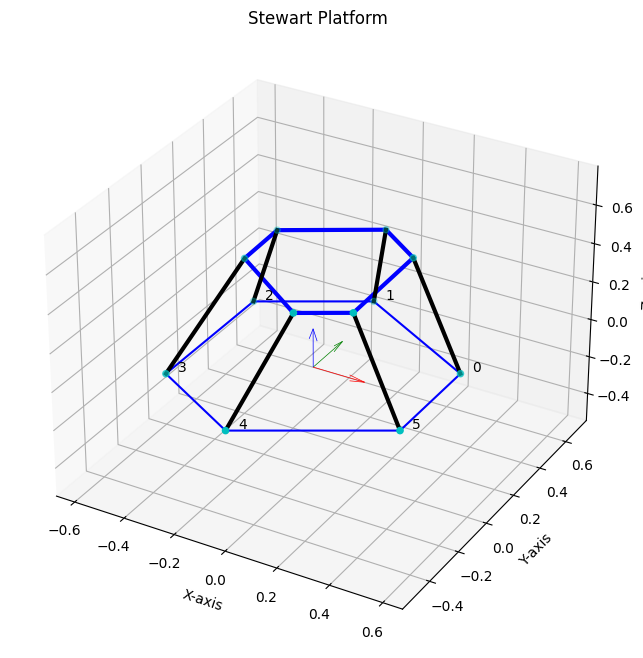

closest singularity : [-0.16666667  0.38888889  0.21111111  7.77777778  1.11111111 -3.33333333]
local condition number T : 0.00031536082915576726
joint_forces : [-1117.01242022   344.28711744   -31.90896656  -993.10013824
   863.4248283    951.8525656 ]


In [ ]:

# find the closest singularity.
pose=np.array([0,0.35,0.2,0,0,0])
mins=np.array([x_min,y_min,z_min,roll_min,pitch_min,yaw_min])
maxs=np.array([x_max,y_max,z_max,roll_max,pitch_max,yaw_max])
mins = np.array(mins)
maxs = np.array(maxs)

# Normalize each component
normalized_pose = (pose - mins) / (maxs - mins)
# print(normalized_pose)
normalized_singularities=(singularities_task_space-mins)/(maxs-mins)
# print(normalized_singularities)
distances = np.linalg.norm(normalized_singularities - normalized_pose, axis=1)
# print(distances)
# # Find the index of the minimum distance
min_index = np.argmin(distances)
# print(distances[min_index])

# # Return the closest vector
closest_vector = singularities_task_space[min_index]


k=platform.getLocalConditionIndexT()
lengths=platform.getIK(pose)
k=platform.getLocalConditionIndexT()
Fg=np.array([-10,0,0,0,0,0])

joint_forces=platform.getActuatorForces(Fg)
platform.plot()
print("pose :", pose)
print("local condition number T :", k)
print("joint_forces :", joint_forces)


lengths=platform.getIK(closest_vector)
platform.plot()
k=platform.getLocalConditionIndexT()
joint_forces=platform.getActuatorForces(Fg)
print("closest singularity :", closest_vector)
print("local condition number T :", k)
print("joint_forces :", joint_forces)


In [ ]:
# @title Plotting libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

It is possible to plot 3d the singularity planes as long as we fix either position or orientation.

**Fixing position**

In [ ]:
# Choose a position
position = np.array([-0.45,0.1,0.2])

N=10 # discretization of space
choice=6 # choose choice 6 for local condition index
orientation_limits = [-10, 10, -10, 10, -10, 10] # use same orientation limits as singularity search
roll_min, roll_max, pitch_min, pitch_max, yaw_min, yaw_max = orientation_limits

# use the getIndexWorkspaceOrientation function to see how the local condition index changes when orienting the platform
workspace_indices_orientation = platform.getIndexWorkspaceOrientation(position, orientation_limits, N, choice)


In [ ]:
# @title Plotly orientation
values = np.copy(workspace_indices_orientation[:,3])
X= np.copy(workspace_indices_orientation[:,0])
Y= np.copy(workspace_indices_orientation[:,1])
Z= np.copy(workspace_indices_orientation[:,2])

# isomin_val=min(values);
# isomax_val=max(values);
# isomin_val=0;

# isomax_val=2;

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=20, # needs to be a large number for good volume rendering
    # isomin=isomin_val,
    # isomax=isomax_val,
    caps= dict(x_show=False, y_show=False, z_show=False, x_fill=1), # with caps (default mode)
    ))

fig.update_layout(
    title='Singularities plane in orientation space',
    scene = dict(
    xaxis = dict(nticks=N, range=[roll_min,roll_max],),
                     yaxis = dict(nticks=N, range=[pitch_min,pitch_max],),
                     zaxis = dict(nticks=N, range=[yaw_min,yaw_max],),

    xaxis_title='Roll',
    yaxis_title='Pitch',
    zaxis_title='Yaw',
    ),

    width=700,
    margin=dict(r=0, l=0, b=0, t=40))

fig.show()

**Fixing orientation**

In [ ]:
# Choose an orientation
orientation = np.array([8,7,5]) # RPY
N=10 # discretization of space
choice=6 # choose choice 6 for local condition index
workspace_limits = [-0.5, 0.5, -0.5, 0.5, 0.1, 0.6] # use same workspace limits as singularity search
x_min, x_max, y_min, y_max, z_min, z_max = workspace_limits

# use the getIndexWorkspacePosition function to see how the local condition index changes when positioning the platform
workspace_indices_position = platform.getIndexWorkspacePosition(orientation, workspace_limits, N, choice)


In [ ]:
# @title Plotly Position
values = np.copy(workspace_indices_position[:,3])
X= np.copy(workspace_indices_position[:,0])
Y= np.copy(workspace_indices_position[:,1])
Z= np.copy(workspace_indices_position[:,2])

# isomin_val=min(values);
# isomax_val=max(values);
# isomin_val=0;
# isomax_val=2;

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=20, # needs to be a large number for good volume rendering
    # isomin=isomin_val,
    # isomax=isomax_val,
    caps= dict(x_show=False, y_show=False, z_show=False, x_fill=1), # with caps (default mode)
    ))

fig.update_layout(
    title='Singularities plane in position space',
    scene = dict(
    xaxis = dict(nticks=N, range=[x_min,x_max],),
                     yaxis = dict(nticks=N, range=[y_min,y_max],),
                     zaxis = dict(nticks=N, range=[z_min,z_max],),

    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z',
    ),

    width=700,
    margin=dict(r=0, l=0, b=0, t=40))

fig.show()